In [3]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import glob


'''
This is a Python script that reads in MIPAS CH4 data from a directory of netCDF files, 
processes and bins the data, and then writes the corrected and binned data to new netCDF files.

The script first defines some variables, including the bin size, the input and output directories, 
and a list of variables to exclude from the output netCDF file. 
It then uses the glob module to find all netCDF files in the input directory.

For each input file, the script opens the file and creates new netCDF files for the corrected and binned data. 
It then copies the global attributes and dimensions from the input file to the output file, 
and copies all variables except for the excluded variables. 
The altitude variable is also renamed to 'height' and the altitude data is 
replaced with the mean of the altitude data along each altitude level.

The script then uses xarray to open the corrected data netCDF file, 
resamples the time variable to monthly intervals, and defines the bin edges for latitude and longitude. 
It bins the latitude and longitude values using the numpy digitize function, 
and loops over each altitude level to fill in the binned CH4 values. 
It then creates a new xarray dataset with the binned CH4 values and writes it to a netCDF file.
# using: 
https://stackoverflow.com/questions/15141563/python-netcdf-making-a-copy-of-all-variables-and-attributes-but-one
'''

binsize = 10
input_dir = '/Users/tobias/Downloads/Mipas/'
output_dir = '.'

to_exclude = ['altitude', 'ExcludeVar2']

# Find all the input files in the input directory
input_files = sorted(glob.glob(os.path.join(input_dir, 'MIPAS-E_IMK.??????.V8?_CH4_*61.nc')))

for input_file in input_files:
    print('processing '+input_file)
    
    # Create the output file names for the corrected and binned data
    output_file_corr = os.path.splitext(os.path.join(output_dir, os.path.basename(input_file)))[0] + '_corr.nc'
    output_file_bin = os.path.splitext(os.path.join(output_dir, os.path.basename(input_file)))[0] + '_bin{}_1M.nc'.format(binsize)

    with nc.Dataset(input_file,'r') as src, nc.Dataset(output_file_corr, "w") as dst:
        # Copy global attributes all at once via dictionary
        dst.setncatts(src.__dict__)

        # Copy dimensions
        for name, dimension in src.dimensions.items():
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))

        # Copy all file data except for the excluded
        for name, variable in src.variables.items():
            if name == 'altitude':
                # Rename the altitude variable to height
                x = dst.createVariable('height', variable.dtype, variable.dimensions)
                dst['height'][:] = src[name][:]
                dst['height'].setncatts(src[name].__dict__)
                x = dst.createVariable(name, variable.dtype, ('altitude',))
                dst[name][:] = np.nanmean(src[name][:], axis=1)
                dst['height'].setncatts(src[name].__dict__)
            if name not in to_exclude:
                x = dst.createVariable(name, variable.datatype, variable.dimensions)
                dst[name][:] = src[name][:]
                dst[name].setncatts(src[name].__dict__)

        ds = xr.open_dataset(xr.backends.NetCDF4DataStore(dst))
        ds.load()

    # Now bin the data and write a monthly mean of the binned data.    
    # Resample time to monthly intervals
    monthly_time = ds.time.resample(time="1M").mean().values

    # Define the bin edges for latitude and longitude
    nblat = int((90 - (-90)) / binsize)+1
    nblon = int((180 - (-180)) / binsize)+1
    lat_bins = np.linspace(-90, 90, nblat)
    lon_bins = np.linspace(-180, 180, nblon)

    # Bin the latitude and longitude values
    lat_indices = np.digitize(ds.latitude.values, lat_bins)
    lon_indices = np.digitize(ds.longitude.values, lon_bins)

    # Initialize an empty array to store the binned CH4 values
    n_altitudes = ds.height.shape[0]
    n_lats = len(lat_bins) - 1
    n_lons = len(lon_bins) - 1
    n_time = 1
    ch4_binned = np.empty((n_time, n_altitudes, n_lats, n_lons))
    ch4_binned[:] = np.nan

    # Loop over altitudes and fill in the binned CH4 values
    for alt_idx in range(n_altitudes):
        ch4_alt = ds.target.values[alt_idx]
        for lat_idx in range(n_lats):
            for lon_idx in range(n_lons):
                mask = (lat_indices == lat_idx+1) & (lon_indices == lon_idx+1)
                if np.any(mask):
                    ch4_binned[0, alt_idx, lat_idx, lon_idx] = np.nanmean(ch4_alt[mask])
                else:
                    ch4_binned[0, alt_idx, lat_idx, lon_idx] = np.nan

    # Create a new xarray dataset with the binned CH4 values
    ds_binned = xr.Dataset(
        {"ch4": (["time", "altitude", "latitude", "longitude"], ch4_binned)},
        coords={
            "time": monthly_time,
            "altitude": ds.altitude.values,
            "latitude": lat_bins[:-1] + np.diff(lat_bins)/2,
            "longitude": lon_bins[:-1] + np.diff(lon_bins)/2,
        },
        attrs=ds.attrs,
    )
    ds_binned["ch4"].attrs = ds["target"].attrs

    # Write the monthly average of the binned (lat,lon) data into a netcdf file: 
    ds_binned.to_netcdf(output_file_bin)
print('finished processing')

processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200601.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200702.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200811.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200804.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200907.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200912.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200302.V8H_CH4_61.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200401.V8H_CH4_61.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200306.V8H_CH4_61.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200609.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200311.V8H_CH4_61.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200710.V8R_CH4_261.nc
processing /Users/tobias/Downloads/Mipas/MIPAS-E_IMK.200705.V8R_CH4_261.nc
processing /Users/tobias/Down

In [110]:
dsch4 = xr.open_dataset('MIPAS-E_IMK.V8RH_CH4_261_bin10_1M.nc')
#dsch4['ch4'] = dsch4['ch4'].where(dsch4['ch4'] >= 0, np.nan)

-0.08729897439479828
2005-12-23T10:11:27.019923629 75.0 5.0 85.0
(106, 73) --------
-0.023271892434826844
2003-12-17T21:56:54.863923629 75.0
(106,) --------
1.3267660843474525
2004-12-01T11:06:11.703923629


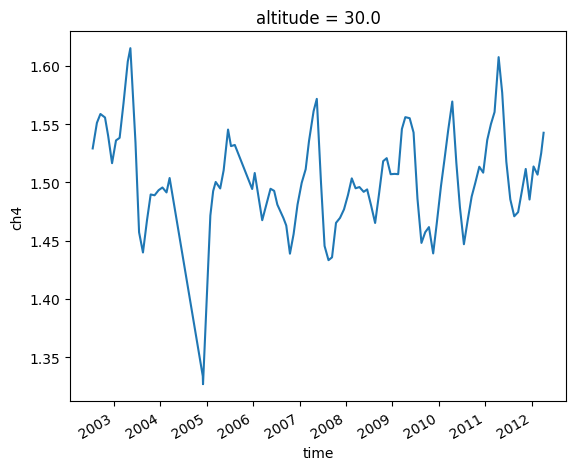

In [111]:
zmean_ch4 = dsch4.ch4.sel(longitude=slice(-360, 360)).mean(dim='longitude')
trop_zmean_ch4 = zmean_ch4.sel(latitude=slice(-10, 10)).mean(dim='latitude')
trop_zmean_ch4.sel(altitude=30, method='nearest').plot()
trop_zmean_ch4.sel(altitude=30, method='nearest')
min_time_indices, min_altitude_indices, min_latitude_indices, min_longitude_indices = np.unravel_index(dsch4.ch4.argmin(), dsch4.ch4.shape)
min_time = dsch4.time[min_time_indices]
min_altitude = dsch4.altitude[min_altitude_indices]
min_latitude = dsch4.latitude[min_latitude_indices]
min_longitude = dsch4.longitude[min_longitude_indices]
print(dsch4.ch4.min().values)
print(min_time.values,min_altitude.values,min_latitude.values,min_longitude.values)

print(trop_zmean_ch4.shape,'--------')
min_time_indices, min_altitude_indices = np.unravel_index(trop_zmean_ch4.argmin(), trop_zmean_ch4.shape)
min_time = trop_zmean_ch4.time[min_time_indices]
min_altitude = trop_zmean_ch4.altitude[min_altitude_indices]
print(trop_zmean_ch4.min().values)
print(min_time.values,min_altitude.values)

trop_zmean_ch4 = trop_zmean_ch4.sel(altitude=30, method='nearest')
print(trop_zmean_ch4.shape,'--------')
min_time_indices = np.unravel_index(trop_zmean_ch4.argmin(), trop_zmean_ch4.shape)
min_time = trop_zmean_ch4.time[min_time_indices]
print(trop_zmean_ch4.min().values)
print(min_time.values)

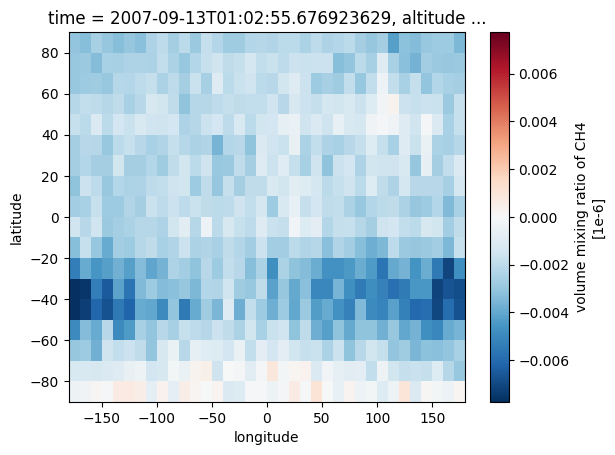

In [112]:
dsch4.ch4[50,69].plot()

In [44]:
min_indices = dsch4.ch4.where(dsch4.ch4 == dsch4.ch4.min(), drop=True).argmin(dim=['time', 'altitude', 'latitude', 'longitude'])


In [45]:
min_indices

{'time': <xarray.DataArray 'ch4' ()>
 array(0),
 'altitude': <xarray.DataArray 'ch4' ()>
 array(0),
 'latitude': <xarray.DataArray 'ch4' ()>
 array(0),
 'longitude': <xarray.DataArray 'ch4' ()>
 array(0)}

In [46]:
(min_time_indices, min_altitude_indices, min_latitude_indices, min_longitude_indices) = min_indices


In [1]:
min_time_indices

NameError: name 'min_time_indices' is not defined

In [48]:
min_altitude_indices

'altitude'

In [53]:
min_time = dsch4.time[min_time_indices]
min_altitude = dsch4.altitude[min_altitude_indices]
min_latitude = dsch4.latitude[min_latitude_indices]
min_longitude = dsch4.longitude[min_longitude_indices]